In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we've never had before about how different people experience romance.


In this capstone, you will analyze some data from OKCupid, an app that focuses on using multiple choice and short answers to match users.


The dataset provided has the following columns of multiple-choice data:

- body_type
- diet
- drinks
- drugs
- education
- ethnicity
- height
- income
- job
- offspring
- orientation
- pets
- religion
- sex
- sign
- smokes
- speaks
- status

And a set of open short-answer responses to :

- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if…


### Introduction


In this capstone, you will create a presentation about your findings in this OkCupid dataset.


The purpose of this capstone is to practice formulating questions and implementing Machine Learning techniques to answer those questions. We will give you guidance about the kinds of questions we asked, and the kinds of methods we used to answer those questions. But the questions you ask and how you answer them are entirely up to you. We're excited to see what kinds of different things you explore.
Compared to the other projects you have completed this far, we are requiring few restrictions on how you structure your code. The project is far more open-ended, and you should use your creativity. In addition, much of the code you write for later parts of this project will depend on how you decided to implement earlier parts. **Therefore, we strongly encourage you to read through the entire assignment before writing any code.**
________________


### Load in the DataFrame


The data is stored in **profiles.csv**. We can start to work with it in **dating.py** by using Pandas, which we have imported for you with the line:


```
import pandas as pd
```


and then loading the csv into a DataFrame: 


```
df = pd.read_csv("profiles.csv")
```


### Explore the Data


Let's make sure we understand what these columns represent!

Pick some columns and call `.head()` on them to see the first five rows of data. For example, we were curious about `job`, so we called:


```
df.job.head()
```


You can also call `value_counts()` on a column to figure out what possible responses there are, and how many of each response there was.


### Visualize some of the Data


We can start to build graphs from the data by first importing Matplotlib:


```
from matplotlib import pyplot as plt
```


and then making some plots!

For example, we were curious about the distribution of ages on the site, so we made a histogram of the `age` column:


```
plt.hist(df.age, bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xlim(16, 80)
plt.show()
```


Try this code in your own file and take a look at the histogram it produces!


### Formulate a Question


As we started to look at this data, we started to get more and more curious about Zodiac signs. First, we looked at all of the possible values for Zodiac signs:


```
df.sign.value_counts()
```


We started to wonder if there was a way to predict a user's Zodiac sign from the information in their profile. Thinking about the columns we had already explored, we thought that maybe we could classify Zodiac signs using drinking, smoking, drugs, and essays as our features.




### Augment your Data


In order to answer the question you've formulated, you will probably need to create some new columns in the DataFrame. This is especially true because so much of our data here is categorical (i.e. `diet` consists of the options `vegan`, `vegetarian`, `anything`, etc. instead of numerical values).


Categorical data is great to use as labels, but we want to create some numerical data as well to use for features.


For our question about Zodiac signs, we wanted to transform the `drinks` column into numerical data. We used:


```
drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}


all_data["drinks_code"] = all_data.drinks.map(drink_mapping)
```


These lines of code created a new column called 'drinks_code' that mapped the following `drinks` values to these numbers:


| drinks      | drinks_code |
|-------------|-------------|
| not at all  | 0           |
| rarely      | 1           |
| socially    | 2           |
| often       | 3           |
| very often  | 4           |
| desperately | 5           |


We did the same for `smokes` and `drugs`.


We also wanted some numerical data about the short answer essays. We combined them all into one string, took out the `NaN`s, and then created a new column called `essay_len`:


```
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]


# Removing the NaNs
all_essays = all_data[essay_cols].replace(np.nan, '', regex=True)
# Combining the essays
all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)


all_data["essay_len"] = all_essays.apply(lambda x: len(x)))
```


We also created a column with average word length and a column with the frequency of the words "I" or "me" appearing in the essays.


### Normalize your Data!


In order to get accurate results, we should make sure our numerical data all has the same weight.


For our Zodiac features, we used:


```
feature_data = all_data[['smokes_code', 'drinks_code', 'drugs_code', 'essay_len', 'avg_word_length']]


x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)
```


### Use Classification Techniques


We have learned how to perform classification in a few different ways.


- We learned about K-Nearest Neighbors by exploring IMDB ratings of popular movies 
- We learned about Support Vector Machines by exploring baseball statistics
- We learned about Naive Bayes by exploring Amazon Reviews


Some questions we used classification to tackle were:


- Can we predict sex with education level and income??
- Can we predict education level with essay text word counts?


### Use Regression Techniques


We have learned how to perform Multiple Linear Regression by playing with StreetEasy apartment data. Is there a way we can apply the techniques we learned to this dataset?


Some questions we used regression to tackle were:


- Predict income with length of essays and average word length?
- Predict age with the frequency of "I" or "me" in essays?


We also learned about K-Nearest Neighbors Regression. Which form of regression works better to answer your question?


### Analyze the Accuracy, Precision and Recall


After you have trained your model and run it, you will probably be curious about how well it did.


Find the accuracy, precision, and recall of each model you used, and create graphs showing how they changed.


For our question of classifying Zodiac signs, one graph we produced showed classification accuracy versus `k` (for K-Nearest Neighbors):
![accuracy vs k](https://s3.amazonaws.com/codecademy-content/programs/machine-learning/capstone/Zodiac_Accuracy.png)


The accuracy we would expect from predicting a Zodiac sign by randomly selecting one would be 1/12, or 0.0833. Our model did not significantly outperform this number. We were unimpressed.


### Create your Presentation


We want to see:


- at least two graphs containing exploration of the dataset
- a statement of your question (or questions!) and how you arrived there 
- the explanation of at least two new columns you created and how you did it
- the comparison between two classification approaches, including a qualitative discussion of simplicity, time to run the model, and accuracy, precision, and/or recall
- the comparison between two regression approaches, including a qualitative discussion of simplicity, time to run the model, and accuracy, precision, and/or recall
- an overall conclusion, with a preliminary answer to your initial question(s), next steps, and what other data you would like to have in order to better answer your question(s)


Good luck!

<h1>Imports</h1>

In [103]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests as req
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

<h1>Check dataset</h1>

In [2]:
profiles = pd.read_csv("profiles.csv")
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
age            59946 non-null int64
body_type      54650 non-null object
diet           35551 non-null object
drinks         56961 non-null object
drugs          45866 non-null object
education      53318 non-null object
essay0         54458 non-null object
essay1         52374 non-null object
essay2         50308 non-null object
essay3         48470 non-null object
essay4         49409 non-null object
essay5         49096 non-null object
essay6         46175 non-null object
essay7         47495 non-null object
essay8         40721 non-null object
essay9         47343 non-null object
ethnicity      54266 non-null object
height         59943 non-null float64
income         59946 non-null int64
job            51748 non-null object
last_online    59946 non-null object
location       59946 non-null object
offspring      24385 non-null object
orientation    59946 non-null object
pets

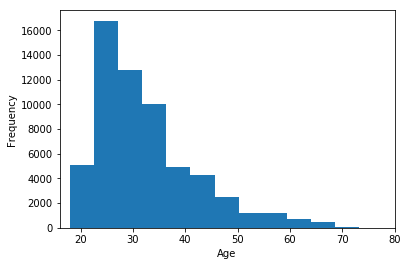

In [3]:
plt.hist(profiles.age, bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xlim(16, 80)
plt.show()

In [4]:
#profiles.body_type.value_counts()

In [5]:
#profiles.diet.value_counts()

In [6]:
#profiles.education.value_counts()

In [7]:
#profiles.ethnicity.value_counts()

In [8]:
#profiles.height.value_counts()

In [9]:
#profiles.income.value_counts()

In [10]:
#profiles.job.value_counts()

In [11]:
#profiles.offspring.value_counts()

In [12]:
#profiles.orientation.value_counts()

In [13]:
#profiles.pets.value_counts()

In [14]:
#profiles.religion.value_counts()

In [15]:
#profiles.sex.value_counts()

In [16]:
#profiles.speaks.value_counts()

In [17]:
profiles.drugs.value_counts()
drugs_mapping={
    np.nan: -1,
    'never':0,
    'sometimes':1,
    'often':2
}
profiles['drugscode']=profiles.drugs.map(drugs_mapping)

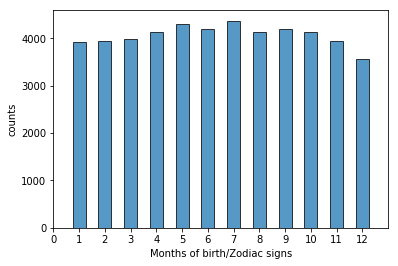

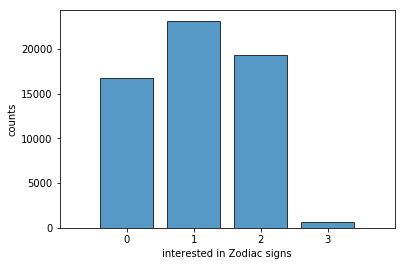

In [18]:
import re

profiles.sign.value_counts()
profiles.sign.head()
sign = profiles.sign.apply(lambda x: str(x).split(' ')[0])

profiles.sign=profiles.sign.replace(np.nan, '', regex=True)

sign_mapping={
    'aquarius':1,
    'pisces':2,
    'aries':3,
    'taurus':4,
    'gemini':5,
    'cancer':6,
    'leo':7,
    'virgo':8,
    'libra':9,
    'scorpio':10,
    'sagittarius':11,
    'capricorn':12
}

profiles['signcode']=sign.map(sign_mapping)

#0: not interested in Zodiac signs
#1: just gave the value
#2: its fun to think about
#3: it matters a lot
regex_fun = re.compile('.*?fun to think about.*?')
regex_not = re.compile('.*?but it doesn.*?')
regex_lot = re.compile('.*?matters a lot.*?')

def get_weight(x):
    if regex_fun.match(x) is not None:
        return 2
    elif regex_lot.match(x) is not None:
        return 3
    elif regex_not.match(x) is not None:
        return 0
    else:
        return 1

signcode_w=[]
for i in profiles['sign']:
    signcode_w.append(get_weight(i))
    
profiles['signcode_w']=signcode_w


#profiles.signcode_w.value_counts()

plt.rcParams["patch.force_edgecolor"] = True

fig1=plt.figure(1)
plt.subplot(111)
plt.hist(profiles.signcode.dropna(), bins=np.arange(14)-0.5, alpha=0.75, rwidth=0.5)
plt.xlabel('Months of birth/Zodiac signs')
plt.ylabel('counts')
plt.xticks(range(13))
plt.xlim(0,13)
fig1.savefig('zodiac_months.png')

fig2=plt.figure(2)
plt.subplot(111)
plt.hist(profiles.signcode_w.dropna(), bins=np.arange(6)-0.5, alpha=0.75, rwidth=0.8)
plt.xlabel('interested in Zodiac signs')
plt.ylabel('counts')
plt.xticks(range(4))
plt.xlim(-1,4)
fig2.savefig('zodiac_interests.png')

plt.show()


In [19]:
profiles.smokes.value_counts()
smokes_mapping={
    'no':0,
    'trying to quit':1,
    'sometimes':2,
    'when drinking':3,
    'yes':4
}
profiles['smokescode']=profiles.smokes.map(smokes_mapping)

In [20]:
profiles.status.value_counts()

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

<h1>Create mappings</h1>

<h2>Map location</h2>

In [21]:
'''
#I ran this just first time and then I saved the data in CSV (It was translated within the $300 limit of the geolocation API ;-)
loc = profiles.location
lonlat = pd.DataFrame(columns={'lat','lng'})
for x in loc:
    maps_req = req.get("https://maps.google.com/maps/api/geocode/json?key=###myGeolocationAPIKey###&address="+x)
    maps=maps_req.json()
    coordinates=maps['results'][0]['geometry']['location']
    coordinates = pd.DataFrame([coordinates], columns=coordinates.keys())
    lonlat = lonlat.append([coordinates], ignore_index=True)
'''

'\n#I ran this just first time and then I saved the data in CSV (It was translated within the $300 limit of the geolocation API ;-)\nloc = profiles.location\nlonlat = pd.DataFrame(columns={\'lat\',\'lng\'})\nfor x in loc:\n    maps_req = req.get("https://maps.google.com/maps/api/geocode/json?key=###myGeolocationAPIKey###&address="+x)\n    maps=maps_req.json()\n    coordinates=maps[\'results\'][0][\'geometry\'][\'location\']\n    coordinates = pd.DataFrame([coordinates], columns=coordinates.keys())\n    lonlat = lonlat.append([coordinates], ignore_index=True)\n'

In [22]:
lonlat = pd.read_csv("lonlat.csv")
profiles['lon']=lonlat.values[:, 0]
profiles['lat']=lonlat.values[:, 1]
'''
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='#AAAAAA',lake_color='#FFFFFF')

m.drawmapboundary(fill_color='#FFFFFF')
plt.title("Locations of OKCupid members")

x1, y1 = m(profiles['lon'].values.tolist(),profiles['lat'].values.tolist())
m.scatter(x1, y1, zorder=100, color='red')

plt.savefig('Location_of_members.png')

plt.show()
'''

'\nfrom mpl_toolkits.basemap import Basemap\nm = Basemap(projection=\'mill\',llcrnrlat=-60,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution=\'c\')\nm.drawcoastlines()\nm.fillcontinents(color=\'#AAAAAA\',lake_color=\'#FFFFFF\')\n\nm.drawmapboundary(fill_color=\'#FFFFFF\')\nplt.title("Locations of OKCupid members")\n\nx1, y1 = m(profiles[\'lon\'].values.tolist(),profiles[\'lat\'].values.tolist())\nm.scatter(x1, y1, zorder=100, color=\'red\')\n\nplt.savefig(\'Location_of_members.png\')\n\nplt.show()\n'

In [23]:
profiles['east_of_great_plains']=profiles['lon'].apply(lambda x: x > -122.419)
profiles['east_of_great_plains'].value_counts()

#print(profiles['lon'].mean())

False    34514
True     25432
Name: east_of_great_plains, dtype: int64

In [94]:
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]

all_essays = profiles[essay_cols].replace(np.nan, '', regex=True)

all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)

profiles['all_essays']=all_essays

profiles["essay_len"] = all_essays.apply(lambda x: len(x))

essay_cols.append('essay_len')

profiles['all_essays'].head()


0    about me:<br />\n<br />\ni would love to think...
1    i am a chef: this is what that means.<br />\n1...
2    i'm not ashamed of much, but writing public te...
3    i work in a library and go to school. . . read...
4    hey how's it going? currently vague on the pro...
Name: all_essays, dtype: object

<H1>Normalize</H1>

In [99]:
import sklearn.preprocessing as pre
feature_data_prescaled = profiles[['smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', 'income']].dropna()


x = feature_data_prescaled.values
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data_prescaled.columns)
feature_data.head(3)


,smokescode,drugscode,essay_len,signcode,signcode_w,height,income
0,0.5,0.333333,0.027372,0.363636,0.333333,0.787234,0.000000
1,0.0,0.666667,0.015000,0.454545,0.333333,0.734043,0.080001
2,0.0,0.000000,0.057215,0.090909,0.000000,0.712766,0.000000


<h1>Classification</h1>

In [101]:
%%time
profiles_explore=profiles[['all_essays', 'signcode']].dropna()

train_data, test_data, train_labels, test_labels = \
                            train_test_split(profiles_explore['all_essays'], \
                            profiles_explore['signcode'], test_size=0.2, random_state=1)


counter = CountVectorizer()
counter.fit(profiles_explore['all_essays'])

train_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)

classifier = MultinomialNB()
classifier.fit(train_data, train_labels)
predictions = classifier.predict(test_data)

print(accuracy_score(test_labels, predictions))
print(recall_score(test_labels, predictions, average='micro'))
print(precision_score(test_labels, predictions, average='micro'))
print(f1_score(test_labels, predictions, average='micro'))
%time



ValueError: could not convert string to float: 'none of my pics reflect my eyes anymore .. need to update\nsoon<br />\n\'ve become a new person again .. email me if you frequently do too\n:)<br />\n<br />\nold profile:<br />\ni a small cross section of the universe experiencing and observing\nitself subjectively. no eye can see itself, no thing can experience\nitself all at once unless we realize the nature of what we really\nare and focus on the mirror behind the illusion (or go further and\nrealize there is no mirror or illusion)<br />\n<br />\nbut that pretty much applies to anyone who chooses to entertain\nsimilar reality-tunnels as mine.<br />\n<br />\n"i" am also..<br />\n<br />\nnomadic transient wannabe-eurotrash fag. promiscuous, androgynous,\nof dubious sexuality. painter, artist, writer, musician. urban\nbodhisattva. cassadyan conman. i\'m not vegan but i eat like one.\nliving la vie boheme. devotee of the dionysian. novelty whore and\ninspiration junkie<br />\n<br />\ni am a devout servant to catalyzing evolution, realizing and\nhelping others realize the full potential of their mind in order to\nbenefit the most beings as quickly and efficiently as\npossible.<br />\n<br />\ni am also totally full of shit.<br />\n<br />\nthe best way i can think of answering this prompt is to ask "who is\nthe one who is living me now?"<br />\n<br />\ni am an artist, a man, and a failure enjoying it (and learning a lot). hoping to fall in love. creating\nart. trying to bring as much joy benefit and chaos to all beings as\ni can. trying to live sustainably and leave everything i interact\nwith untouched or improved. certainly not working for the man.\nfiending for cock. traveling around the world exploring foreign\ncultures, communing with nature, learning languages, meeting\nawesome people, squatting in dirty basements and sleeping in parks.\ni want to spend little chunks of time (6 mos - 2 yrs) living in\nvarious places that interest me, such as the pacific northwest,\nparis, berlin, tokyo, india, anywhere in southeast asia/pacific\nislands, ethiopia, prague, tallinn, switzerland...you know i\'ve\nalready got a year in germany, 3 months in peru, and 4+ in the bay\narea, as well as vacationing.. i paint, and play guitar, and read\nand write a lot. i meditate, do t\'ai chi, go to protests, engage in\nactivism and try to think of alternatives to protesting that\nactually work. one thing i do with a very vast portion of my life\nis sleep. another thing i do a lot is dream. i enjoy fetish events\nthat involve queer people from all kinds of genders and sexualities\ndressed in adorable pvc and fishnets tying one another up and\nflogging each other :)  my tits and ass a) bear v. shark - chris bachelder, tropic of cancer - henry\nmiller, naked lunch - william s burroughs, taz - hakim bey,\nprometheus rising - robert anton wilson, shower of gold - donald\nbarthelme, to kill a child - stig dagerman, waiting for godot -\nsamuel beckett, lot\'s of stuff by tom robbins, e.e. cummings, allen\nginsberg, franz kafka..<br />\n<br />\nb) <a class="ilink" href=\n"/interests?i=wir+kinder+vom+bahnhof+zoo">wir kinder vom bahnhof\nzoo</a>, kids, fear and loathing in las vegas, all things johnny\ndepp really, requiem for a dream, pi, memento, american beauty,\nmonty python\'s meaning of life, spirited away, irreversible, a\nscanner darkly,<br />\n<br />\nc) coil, merzbow, maenad, tool, a perfect circle, nine inch nails,\nsun ra, john coltrane, frank zappa, captain beefheart, skerik,\naphex twin, alva.noto, modest mouse, bright eyes<br />\n<br />\nd) falafel, hummus, samosas, eggplant, curry, um, pretty much\nanything mexican, middle eastern, persian, indian, east\nasian...love sushi, avocado, olives, baguettes, oil infused with\nherbs, fine wine, anything hemp *) top<br />\n<br />\n*) bottom<br />\n<br />\n*) front<br />\n<br />\n*) back<br />\n<br />\n*) left<br />\n<br />\n*) right where we come from, what we are, and where we are going.<br />\n<br />\nlearning and entertainment.<br />\n<br />\nmetaprogramming.<br />\n<br />\napplying oil paints to canvas.<br />\n<br />\n2,4,5-ring substitution patterns.<br />\n<br />\nparadoxes, infinity, synchronicities, hyperdimensional\nrealms..<br />\n<br />\npeople, society, relationships..<br />\n<br />\nfashion&amp;eyeliner;<br />\n<br />\ng protein-coupled receptors<br />\n<br />\nlinguistics and language.<br />\n<br />\nbiochemistry, ontology/theology/spirituality/philosophy, activism\n(environmental, social, civil, sometimes political).<br />\n<br />\nthe fact that most modern spell-checking programs don\'t recognize\nmany of the most important words i use.<br />\n<br />\nhow to best remove the ignorance and obscuration which cloud the\nminds of most beings. apparently this particular friday night<br />\n<br />\ni\'m sitting at home on okcupid<br />\n<br />\ntrying to figure out what people who are like me<br />\n<br />\nand/or people i want to be with<br />\n<br />\ndo on a typical friday night<br />\n<br />\nwanna hang out? i confess i continue to be completely boggled by this box...<br />\n<br />\n(tell me who you are and i\'ll tell you anything you want to know) that\'s how it\'s gonna go down'

In [88]:
%%time
feature_data_prescaled = \
    profiles[['smokescode', 'drugscode', 'essay_len', 'height', 'income']].dropna()

x = feature_data_prescaled.values
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data_prescaled.columns)

train_data, test_data, train_labels, test_labels = \
    train_test_split(feature_data[['drugscode', 'smokescode', 'essay_len', 'height']], \
    feature_data_prescaled['income'], test_size=0.2, random_state=1)
    
classifier = MultinomialNB()
classifier.fit(train_data, train_labels)
predictions = classifier.predict(test_data)

#print(accuracy_score(test_labels, predictions))
#print(recall_score(test_labels, predictions, average='micro'))
#print(precision_score(test_labels, predictions, average='micro'))
print(f1_score(test_labels, predictions, average='micro'))
%time

0.800128593735648
Wall time: 0 ns
Wall time: 47 ms


In [188]:
%%time
from sklearn.metrics import r2_score

feature_data_prescaled = \
    profiles[['smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', 'income', 'lat', 'lon']].dropna()

x = feature_data_prescaled.values
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data_prescaled.columns)

train_data, test_data, train_labels, test_labels = \
    train_test_split(feature_data[['smokescode', 'drugscode', 'signcode', 'signcode_w', 'height', 'income', 'lat', 'lon']], \
    feature_data['essay_len'], test_size=0.2, random_state=1)
    
regression = linear_model.LinearRegression()
regression.fit(train_data, train_labels)
predictions = regression.predict(test_data)

print(r2_score(test_labels, predictions))
%time

0.0067885064686815655
Wall time: 0 ns
Wall time: 46 ms


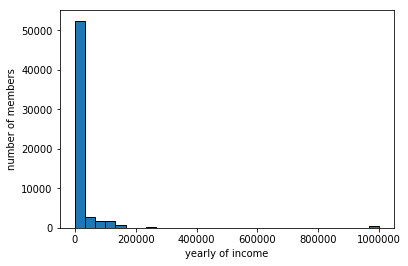

In [185]:
plt.hist(profiles.income, bins=30)
plt.ylabel('number of members')
plt.xlabel('yearly of income')
plt.show()